<h1 style="text-align:center;">Sequence–Structure Relationships in AF3 Models of YF Epitope–TCR Complexes</h1>

In [9]:
import os
import glob
import shutil
import pandas as pd
import numpy as np
import re

from Bio.PDB import PDBList
from pathlib import Path
from Bio.PDB import PDBParser, NeighborSearch, PDBIO, Superimposer, MMCIFParser
from Bio.SeqUtils import seq1

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import MDAnalysis as mda
from MDAnalysis.coordinates.PDB import PDBWriter
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances

std_pal = sns.color_palette("deep")

# Download

In [ ]:
def download_pdb(pdb_id, out_dir="pdbs"):
    """
    Download a PDB structure from RCSB.
    """
    pdb_id = pdb_id.lower()
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    try:
        pdbl = PDBList()
        raw_path = pdbl.retrieve_pdb_file(
            pdb_id,
            pdir=str(out_dir),
            file_format='pdb',
            overwrite=True
        )

        raw_path = Path(raw_path)
        clean_path = out_dir / f"{pdb_id}.pdb"
        raw_path.rename(clean_path)
    
    except Exception as e:
        print(f"[ERROR] Could not download {pdb_id}: {e}")
        return None


In [ ]:
df = pd.read_csv('tcr_pdbs_david.csv', sep=';')
outdir = 'pdbs' # directory for downloaded pdb files

for _, row in df.iterrows():
    # download PDB
    download_pdb(row.PDB, outdir)

# Annotate Chains

In [ ]:
def get_chain_sequences(pdb_file):
    """ 
    Create dictionary with all chain ids and the corresponding sequence. 
    """

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('tcr', pdb_file)
    
    chain_seqs = {}
    for chain in structure.get_chains():
        residues = [
            res for res in chain
            if res.id[0] == " "  # exclude hetero/water
        ]
        if not residues:
            continue
        
        seq = "".join(seq1(res.resname) for res in residues)
        chain_seqs[chain.id] = seq

    return chain_seqs

def find_epitope_chains(chain_seqs, epitope):
    return [
        cid for cid, seq in chain_seqs.items()
        if seq.upper() == epitope.upper()
    ]

def find_tcr_chains_by_cdr(chain_seqs, cdrs):
    hits = []
    for chain_id, seq in chain_seqs.items():
        n_hits = sum(cdr.lower() in seq.lower() for cdr in cdrs)
        if n_hits >= 2:
            hits.append(chain_id)
    return hits

def is_beta2m(seq):
    return 85 <= len(seq) <= 120

def find_mhci_alpha_from_beta2m(chain_seqs, beta2m_ids, excluded_ids):
    """
    Infer MHC-I alpha as remaining extracellular chains once beta2m is known.
    Returns only chain IDs (not seqs).
    """
    candidates = [
        (cid, seq)
        for cid, seq in chain_seqs.items()
        if cid not in excluded_ids
        and cid not in beta2m_ids
        and len(seq) >= 250
    ]
    # return only the chain IDs
    return [cid for cid, seq in candidates]


def chains_in_contact_count(structure, ref_chain_id, candidate_chain_ids, cutoff=8.0):
    """
    Helper to get chains with maximal contacts to epitope.
    """
    model = structure[0]
    ref_chain = model[ref_chain_id]
    # unfold all C-alpha atoms in the reference chain
    ref_atoms = [atom for res in ref_chain for atom in res if atom.get_name() == 'CA']

    # all C-alpha atoms in the structure
    all_atoms = [atom for chain in model for res in chain for atom in res if atom.get_name() == 'CA']
    ns = NeighborSearch(all_atoms)

    counts = {}
    for cid in candidate_chain_ids:
        candidate_atoms = [atom for res in model[cid] for atom in res if atom.get_name() == 'CA']
        contact_atoms = set()
        for atom in candidate_atoms:
            neighbors = ns.search(atom.coord, cutoff)
            # count only neighbors in ref_atoms
            if any(n in ref_atoms for n in neighbors):
                contact_atoms.add(atom)
        counts[cid] = len(contact_atoms)

    return counts


def min_ca_distance(structure, ref_chain_id, candidate_chain_ids):
    """
    Helper to get chains with minimum CA distance to epitope.
    """
    model = structure[0]
    ref_chain = model[ref_chain_id]

    ref_atoms = [
        atom for res in ref_chain
        for atom in res if atom.get_name() == 'CA'
    ]

    distances = {}
    for cid in candidate_chain_ids:
        candidate_atoms = [
            atom for res in model[cid]
            for atom in res if atom.get_name() == 'CA'
        ]
        if not candidate_atoms:
            distances[cid] = np.inf
            continue

        min_dist = min(
            np.linalg.norm(a.coord - b.coord)
            for a in candidate_atoms
            for b in ref_atoms
        )
        distances[cid] = min_dist

    return distances



def select_first_complex(structure, chain_seqs, row):
    # 1. pick epitope with lowest chain ID
    epitope_chains = find_epitope_chains(chain_seqs, row.epitope)
    if not epitope_chains:
        return {}
    epitope_chain = sorted(epitope_chains)[0]

    remaining = {cid: seq for cid, seq in chain_seqs.items() if cid != epitope_chain}

    # 2. pick TCR alpha/beta chains with most contacts (or smallest distance)
    tcr_alpha_candidates = find_tcr_chains_by_cdr(remaining, [row.CDR1A,row.CDR2A,row.CDR3A])
    tcr_beta_candidates  = find_tcr_chains_by_cdr(remaining, [row.CDR1B,row.CDR2B,row.CDR3B])
    
    tcr_alpha_counts = chains_in_contact_count(structure, epitope_chain, tcr_alpha_candidates)
    tcr_beta_counts  = chains_in_contact_count(structure, epitope_chain, tcr_beta_candidates)
    
    # TCR alpha
    if tcr_alpha_counts and max(tcr_alpha_counts.values()) > 0:
        tcr_alpha_chain = max(tcr_alpha_counts, key=tcr_alpha_counts.get)
    elif tcr_alpha_candidates:
        alpha_distances = min_ca_distance(structure, epitope_chain, tcr_alpha_candidates)
        tcr_alpha_chain = min(alpha_distances, key=alpha_distances.get)
    else:
        tcr_alpha_chain = None

    # TCR beta
    if tcr_beta_counts and max(tcr_beta_counts.values()) > 0:
        tcr_beta_chain = max(tcr_beta_counts, key=tcr_beta_counts.get)
    elif tcr_beta_candidates:
        beta_distances = min_ca_distance(structure, epitope_chain, tcr_beta_candidates)
        tcr_beta_chain = min(beta_distances, key=beta_distances.get)
    else:
        tcr_beta_chain = None


    used_ids = set(epitope_chains + tcr_alpha_candidates + tcr_beta_candidates)

    # 3. MHC chains: split remaining into candidates
    remaining = {cid: seq for cid, seq in remaining.items() if cid not in used_ids}

    # MHC-I: look for beta2m first
    beta2m_candidates = [cid for cid, seq in remaining.items() if is_beta2m(seq)]

    if beta2m_candidates:
        # MHC-I 
        mhci_alpha_candidates = [cid for cid in remaining if cid not in beta2m_candidates]
        
        # count contacts to epitope
        mhci_alpha_counts = chains_in_contact_count(structure, epitope_chain, mhci_alpha_candidates)
        mhci_alpha_chain = max(mhci_alpha_counts, key=mhci_alpha_counts.get)
        roles = {
            'epitope_chain': epitope_chain,
            'tcr_alpha_chain': tcr_alpha_chain,
            'tcr_beta_chain': tcr_beta_chain,
            'mhci_alpha_chain': mhci_alpha_chain,
        }
    else:
        # MHC-II
        mhcii_candidates = [cid for cid, seq in remaining.items()]

        if len(mhcii_candidates) < 2:
            return {}

        mhcii_counts = chains_in_contact_count(
            structure, epitope_chain, mhcii_candidates
        )

        # get the two chains with the highest contact counts
        top_two = sorted(
            mhcii_counts.items(),
            key=lambda x: x[1],
            reverse=True)[:2]

        # order those two by chain ID
        chain_ids = sorted(cid for cid, _ in top_two)
        mhcii_alpha, mhcii_beta = chain_ids[0], chain_ids[1]


        roles = {
            'epitope_chain': epitope_chain,
            'tcr_alpha_chain': tcr_alpha_chain,
            'tcr_beta_chain': tcr_beta_chain,
            'mhcii_alpha_chain': mhcii_alpha,
            'mhcii_beta_chain': mhcii_beta
        }

    return roles



In [37]:
df = pd.read_csv('tcr_pdbs_david.csv', sep=';')
test = ['6uon']
#df = df[df['PDB'].isin(test)]
outdir = 'pdbs' # directory for downloaded pdb files

for idx, row in df.iterrows():
    # get sequence for each chain
    pdb_file = os.path.join(outdir, f'{row.PDB}.pdb')

    if not os.path.exists(pdb_file):
        continue

    chain_seqs = get_chain_sequences(pdb_file)
    structure = PDBParser(QUIET=True).get_structure('tcr', pdb_file)

    roles = select_first_complex(structure, chain_seqs, row)
    
    for col, cid in roles.items():
        df.at[idx, col] = cid

df.to_csv('tcr_pdbs_chains_david.csv', sep=';', index=False)
    

# Clean PDBs 

In [ ]:
from Bio.PDB import Structure, Model, Chain

def clean_chains(pdb_file, chain_mapping, out_file):
    """
    Keep only specified chains, rename them, and remove water/ions/ligands.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)

    # create new structure
    new_structure = Structure.Structure(structure.id)
    new_model = Model.Model(0)
    new_structure.add(new_model)

    model = structure[0]

    for old_chain_id, new_chain_id in chain_mapping.items():
        if old_chain_id not in model:
            continue  # skip missing chains
        old_chain = model[old_chain_id]

        # create new chain
        new_chain = Chain.Chain(new_chain_id)

        for residue in old_chain:
            # skip water and hetero residues
            if residue.id[0] != ' ':
                continue
            new_chain.add(residue.copy())

        new_model.add(new_chain)

    # save cleaned PDB
    io = PDBIO()
    io.set_structure(new_structure)
    io.save(out_file)


In [ ]:
df = pd.read_csv('tcr_pdbs_chains_david.csv', sep=';')

indir = 'pdbs'
outdir = 'pdbs_clean'
os.makedirs(outdir, exist_ok=True)

for idx, row in df.iterrows():
    # get sequence for each chain
    pdb_file = os.path.join(indir, f'{row.PDB}.pdb')

    if not os.path.exists(pdb_file):
        continue

    chain_mapping = {}
    if pd.notna(row.mhci_alpha_chain):
        chain_mapping[row.mhci_alpha_chain] = 'A'
    if pd.notna(row.mhcii_alpha_chain):
        chain_mapping[row.mhcii_alpha_chain] = 'A'
    if pd.notna(row.mhcii_beta_chain):
        chain_mapping[row.mhcii_beta_chain] = 'B'
    if pd.notna(row.epitope_chain):
        chain_mapping[row.epitope_chain] = 'C'
    if pd.notna(row.tcr_alpha_chain):
        chain_mapping[row.tcr_alpha_chain] = 'D'
    if pd.notna(row.tcr_beta_chain):
        chain_mapping[row.tcr_beta_chain] = 'E'

    clean_chains(pdb_file, chain_mapping, out_file=os.path.join(outdir, f'{row.PDB}.pdb'))

# Align MHC-I complexes

In [3]:
def align_pdbs(ref_file, mobile_files, output_dir):
    parser = PDBParser(QUIET=True)
    io = PDBIO()

    # Load reference structure (first pdb)
    ref_structure = parser.get_structure("ref", ref_file)
    ref_chain = ref_structure[0]["A"]
    ref_atoms = list(chain for chain in ref_chain.get_atoms() if chain.get_name() == "CA")[:180]

    # Align all other PDBs to reference
    for pdb_path in mobile_files:
        structure = parser.get_structure(os.path.basename(pdb_path), pdb_path)
        chain = structure[0]["A"]
        moving_atoms = list(atom for atom in chain.get_atoms() if atom.get_name() == "CA")[:180]
        
        # Superimpose
        sup = Superimposer()
        sup.set_atoms(ref_atoms, moving_atoms)
        sup.apply(structure.get_atoms())

        # Save aligned PDB
        out_path = os.path.join(output_dir, os.path.basename(pdb_path))
        io.set_structure(structure)
        io.save(out_path)
        print(f"Aligned {pdb_path} -> {out_path}")



In [ ]:
parser = PDBParser(QUIET=True)

indir = 'pdbs_clean'
outdir = 'pdbs_mhci_align'

pdbs = glob.glob(f'{indir}/*.pdb')
pdbs.sort()

# Select MHC-I complexes
pdbs_mhci = []
for pdb_file in pdbs:
    structure = parser.get_structure(os.path.basename(pdb_file), pdb_file)
    model = structure[0]
    chain_ids = [chain.id for chain in model]
    
    if 'B' not in chain_ids:
        pdbs_mhci.append(pdb_file)

# Example usage
os.makedirs(outdir, exist_ok=True)

ref_file = pdbs_mhci[0]
# Save reference to output directory
ref_out_path = os.path.join(outdir, os.path.basename(ref_file))
shutil.copy(ref_file, ref_out_path)

# Align remaining files to reference
mobile_files = pdbs_mhci[1:]
align_pdbs(ref_file, mobile_files, outdir)



pdbs_mhci_align/1ao7.pdb


# PCA on CDRs

In [71]:
def get_chain_sequence(pdb_file, chain_id):
    """
    Get sequence based on chain id.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("tcr", pdb_file)

    seq = []
    for res in structure[0][chain_id]: 
        seq.append(seq1(res.get_resname()))

    return "".join(seq)


def extract_cdr3(sequence, min_len=7, max_len=23):
    """
    Extract CDR3 using conserved C (start) and the F/W-GxG motif (end). Ensures min_len <= CDR3 length <= max_len.
    """
    # find all conserved C positions
    c_positions = [m.start() for m in re.finditer("C", sequence)]
    if not c_positions:
        return None

    # try Cs from last to first (most likely real CDR3 start)
    for c_pos in reversed(c_positions):
        subseq = sequence[c_pos:]

        # find all FGXG / WGXG motifs after this C
        matches = list(re.finditer(r"([FW])G.G", subseq))
        if not matches:
            continue

        # check motifs from LAST to FIRST
        for match in reversed(matches):
            end = c_pos + match.start(1) + 1
            cdr3 = sequence[c_pos:end]

            L = len(cdr3)
            if min_len <= L <= max_len:
                return cdr3

    return None

def extract_cdr_coords(pdb_path, cdr_dict, chain_map={"TRA":"A","TRB":"B"}):
    """
    Extract coordinates of CDRs based on the respective sequences.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pdb", pdb_path)
    
    cdr_coords = {}
    
    for chain_label, chain_id in chain_map.items():
        chain_obj = structure[0][chain_id]
        
        # Get all residues with C-alpha
        residues = [res for res in chain_obj if res.id[0] == " " and "CA" in res]
        
        # Convert 3-letter PDB codes to 1-letter
        seq = "".join([seq1(res.get_resname()) for res in residues])
        
        cdr_coords[chain_label] = {}
        
        # loop over CDR1/2/3
        for i, cdr_key in enumerate([f"CDR1{chain_label[-1]}", f"CDR2{chain_label[-1]}", f"CDR3{chain_label[-1]}"], 1):
            cdr_seq = cdr_dict[cdr_key].upper()
            L = len(cdr_seq)
            
            # find CDR sequence in the chain sequence
            start_idx = seq.find(cdr_seq)
            if start_idx == -1:
                print(f"Warning: CDR {cdr_key} sequence not found in chain {chain_id} of {pdb_path}")
                return None
            
            end_idx = start_idx + L
            
            # extract C-alpha coordinates
            coords = np.array([res["CA"].get_coord() for res in residues[start_idx:end_idx]])
            cdr_coords[chain_label][f"cdr{i}"] = coords
            
    return cdr_coords


def build_coord_matrix(cdr_coord_dict, min_cdr_lengths):
    """
    Build coordinate matrix with fixed-length CDRs.
    """
    coord_matrix = []
    for tcr, chains in cdr_coord_dict.items():
        vec = []
        for chain, cdrs in chains.items():
            for cdr_name in ["cdr1","cdr2"]:
                coords = cdrs[cdr_name]
                L = min_cdr_lengths[chain][cdr_name]
                # first 2 + last L-2
                selected = np.vstack([coords[:2], coords[-(L-2):]])
                vec.extend(selected.flatten())
            # CDR3: first 5 + last L-5
            coords = cdrs["cdr3"]
            L = min_cdr_lengths[chain]["cdr3"]
            selected = np.vstack([coords[:5], coords[-(L-5):]])
            vec.extend(selected.flatten())
        coord_matrix.append(vec)
    
    return np.array(coord_matrix)


In [136]:
# fix CDR3 sequences
df = pd.read_csv('tcr_pdbs_chains_david.csv', sep=';')
indir = 'pdbs_mhci_align'

pdbs = glob.glob(f'{indir}/*.pdb')
pdbs.sort()

fixed_rows = []
for pdb_file in pdbs:
    pdb_id = os.path.basename(pdb_file.split('.')[0])
    row = df[df["PDB"] == pdb_id]

    row = row.iloc[0].copy()

    # get TCR chains
    seq_a = get_chain_sequence(pdb_file, "D")
    seq_b = get_chain_sequence(pdb_file, "E")

    # extract correct CDRs
    cdr3a_fix = extract_cdr3(seq_a)
    cdr3b_fix = extract_cdr3(seq_b)

    row["CDR3A_fix"] = cdr3a_fix
    row["CDR3B_fix"] = cdr3b_fix

    if (cdr3a_fix is None) | (cdr3b_fix is None):
        print(f'Error: CDR3 not found for PDB id. {pdb_id}')
        continue

    fixed_rows.append(row)

df_fixed = pd.DataFrame(fixed_rows)
df_fixed.to_csv('tcr_pdbs_chains_david_mhci_fixed.csv', sep=';', index=False)

Error: CDR3 not found for PDB id. 3vxu


In [ ]:
df = pd.read_csv('tcr_pdbs_chains_david_mhci_fixed.csv', sep=';')
df['CDR3A_fix_short'] = df['CDR3A_fix'].str[1:-1]
df['CDR3B_fix_short'] = df['CDR3B_fix'].str[1:-1]

df["CDR3A_match"] = (df["CDR3A"].str.upper() == df["CDR3A_fix_short"].str.upper())
df["CDR3B_match"] = (df["CDR3B"].str.upper() == df["CDR3B_fix_short"].str.upper())
df.to_csv('TableS3_contact_CDR3_typos.csv', sep=';')
df

In [ ]:
df = pd.read_csv('tcr_pdbs_chains_david_mhci_fixed.csv', sep=';')
indir = 'pdbs_mhci_align'

pdbs = glob.glob(f'{indir}/*.pdb')
pdbs.sort()
pdbs = [p for p in pdbs if os.path.basename(p.split('.')[0]) in df['PDB'].values]

cdr_coord_dict = {}
for pdb_file in pdbs:
    pdb_id = os.path.basename(pdb_file.split('.')[0])
    
    # exctract CDR coordinates
    row = df[df["PDB"] == pdb_id]
    cdr_dict = {cdr: str(row[cdr].values[0]).upper() for cdr in ["CDR1A","CDR2A","CDR3A_fix","CDR1B","CDR2B","CDR3B_fix"]}
    cdr_dict['CDR3A'] = cdr_dict.pop('CDR3A_fix') # rename dict keys
    cdr_dict['CDR3B'] = cdr_dict.pop('CDR3B_fix')

    cdr_coords = extract_cdr_coords(pdb_file, cdr_dict, chain_map={"TRA":"D","TRB":"E"})
    cdr_coord_dict[pdb_id] = cdr_coords

# minimal CDR lengths
min_cdr_lengths = {}
for chain_label in ["TRA","TRB"]:
    min_cdr_lengths[chain_label] = {}
    for cdr_name in ["cdr1","cdr2","cdr3"]:
        min_len = min(cdr_coord_dict[pdb_id][chain_label][cdr_name].shape[0] 
                    for pdb_id in cdr_coord_dict)
        min_cdr_lengths[chain_label][cdr_name] = min_len
print(min_cdr_lengths)

# build coordinate matrix and perform pca
coord_matrix = build_coord_matrix(cdr_coord_dict, min_cdr_lengths)
pca = PCA(n_components=2)
pcs = pca.fit_transform(coord_matrix)

df_pca = pd.DataFrame()
df_pca['PC1'] = pcs[:,0]
df_pca['PC2'] = pcs[:,1]
df_pca['PDB'] = np.array(pdbs)
df_pca["PDB"] = df_pca["PDB"].apply(lambda x: os.path.basename(x).split('.')[0])

df_merged = pd.merge(df, df_pca, on='PDB')
df_merged.to_csv('tcr_pdbs_chains_david_mhci_pca.csv', sep=';', index=False)

{'TRA': {'cdr1': 5, 'cdr2': 4, 'cdr3': 10}, 'TRB': {'cdr1': 5, 'cdr2': 5, 'cdr3': 11}}


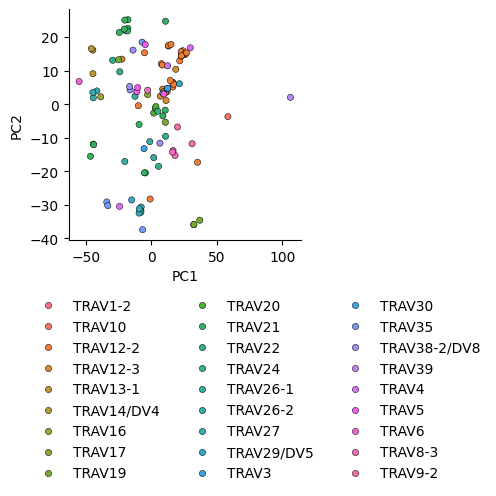

In [99]:
df = pd.read_csv('tcr_pdbs_chains_david_mhci_pca.csv', sep=';')

fig, ax = plt.subplots(1, 1, figsize=(3,3), sharex=True, sharey=True)

seg = 'TRAV'

df = df.sort_values(by=seg)
sns.scatterplot(df, x='PC1', y='PC2', hue=seg, ax=ax, edgecolor='black', s=20)
ax.legend(bbox_to_anchor=(-0.2,-0.2), frameon=False, ncols=3, loc='upper left')
sns.despine()

# Integation of YF-Epitope AF3 models

## Align models

In [4]:
topdir = 'data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']

# align AF3 model to experimental stuctures with lowest pdb id. 
tmp = glob.glob(f'pdbs_clean/*.pdb')
tmp.sort()
ref_file = tmp[0]

for batch in batches:
    # remove TM parts of AF3 models
    indir = f'{topdir}/{batch}/model_pdb_align'
    outdir = f'{topdir}/{batch}/model_pdb_align_trunc'
    os.makedirs(outdir, exist_ok=True)

    pdbs = glob.glob(f'{indir}/*.pdb')
    parser = PDBParser(QUIET=True)
    io = PDBIO()

    for pdb in pdbs:
        structure = parser.get_structure(os.path.basename(pdb), pdb)
        chain_a = structure[0]['A']

        residues_to_delete = [res for res in chain_a if 1 <= res.id[1] <= 24]
        for res in residues_to_delete:
            chain_a.detach_child(res.id)

        out_path = os.path.join(outdir, os.path.basename(pdb))
        io.set_structure(structure)
        io.save(out_path)


    # perfom alignment
    indir = f'{topdir}/{batch}/model_pdb_align_trunc'
    outdir = f'{topdir}/{batch}/model_pdb_align_exp'
    os.makedirs(outdir, exist_ok=True)
    mobile_files = glob.glob(f'{indir}/*.pdb')
    mobile_files.sort()
    
    align_pdbs(ref_file, mobile_files, outdir)

Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0001.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0001.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0005.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0005.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0008.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0008.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0010.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0010.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0012.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0012.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0014.pdb -> data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_exp/tcr0014.pdb
Aligned data_julien/LAU5013/YF_LAU5013_sc_WT/model_pdb_align_trunc/tcr0016.pdb -> data_julien/

## Annotate CDRs and extract coordinates
- use MixTCRviz (R-package): tcr_cdr_annotation.R

In [74]:
cdr_coord_dict = {}

# experimental structures
batch = 'exp'
cdr_coord_dict[batch] = {}

df = pd.read_csv('tcr_pdbs_chains_david_mhci_fixed.csv', sep=';')
indir = 'pdbs_mhci_align'

pdbs = glob.glob(f'{indir}/*.pdb')
pdbs.sort()
pdbs = [p for p in pdbs if os.path.basename(p.split('.')[0]) in df['PDB'].values]

for pdb_file in pdbs:
    pdb_id = os.path.basename(pdb_file.split('.')[0])
    
    # exctract CDR coordinates
    row = df[df["PDB"] == pdb_id]
    cdr_dict = {cdr: str(row[cdr].values[0]).upper() for cdr in ["CDR1A","CDR2A","CDR3A_fix","CDR1B","CDR2B","CDR3B_fix"]}
    cdr_dict['CDR3A'] = cdr_dict.pop('CDR3A_fix') # rename dict keys
    cdr_dict['CDR3B'] = cdr_dict.pop('CDR3B_fix')

    cdr_coords = extract_cdr_coords(pdb_file, cdr_dict, chain_map={"TRA":"D","TRB":"E"})
    cdr_coord_dict[batch][pdb_id] = cdr_coords

# AF models for YF-epitope
topdir = 'data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']
           
for batch in batches:
    batch_short = batch.split('/')[0]
    cdr_coord_dict[batch_short] = {}

    # CDRs annotated with tcr_cdr_annotation.R
    csv_file = glob.glob(f'{topdir}/{batch}/*.csv')[0]
    df = pd.read_csv(csv_file)
    df = df[df["TEMPOproblem"].isna()]

    pdbs = glob.glob(f'{topdir}/{batch}/model_pdb_align_exp/*.pdb')
    pdbs.sort()
    pdbs = [p for p in pdbs if os.path.basename(p.split('.')[0]) in df['id'].values]

    for pdb_file in pdbs:
        pdb_id = os.path.basename(pdb_file.split('.')[0])

        # exctract CDR coordinates
        row = df[df["id"] == pdb_id]
        cdr_dict = {cdr: str(row[cdr].values[0]).upper() for cdr in ["cdr1_TRA","cdr2_TRA","cdr3_TRA","cdr1_TRB","cdr2_TRB","cdr3_TRB"]}
        cdr_dict = { # rename dict keys
            k.replace("cdr", "CDR")  # capitalize 'cdr'
            .replace("_TRA", "A")   # TRA → A
            .replace("_TRB", "B"): v
            for k, v in cdr_dict.items()
        }

        cdr_coords = extract_cdr_coords(pdb_file, cdr_dict, chain_map={"TRA":"B","TRB":"C"})
        if cdr_coords is not None:
            cdr_coord_dict[batch_short][pdb_id] = cdr_coords


# minimal CDR lengths
min_cdr_lengths = {}

for chain_label in ["TRA", "TRB"]:
    min_cdr_lengths[chain_label] = {}
    for cdr_name in ["cdr1", "cdr2", "cdr3"]:
        # collect all lengths across all batches and all pdbs
        all_lengths = []
        for batch, pdbs in cdr_coord_dict.items():           # iterate over batches
            for pdb_id, chains in pdbs.items():             # iterate over pdbs in batch
                coords = chains[chain_label][cdr_name]
                all_lengths.append(coords.shape[0])
        
        # minimal length
        min_cdr_lengths[chain_label][cdr_name] = min(all_lengths)


# build coordinate matrix 
lst = []
for batch, batch_dict in cdr_coord_dict.items():
    coord_matrix = build_coord_matrix(batch_dict, min_cdr_lengths)
    df = pd.DataFrame(coord_matrix)
    df.insert(0, 'batch', batch)  
    df.insert(0, 'PDB', list(batch_dict.keys()))
    lst.append(df)

df = pd.concat(lst)

# annotate germline segments
batches_anno = {
    'exp' : 'tcr_pdbs_chains_david_mhci_fixed.csv',
    'LAU5013' : 'data_julien/LAU5013/YF_LAU5013_sc_WT/YF_LAU5013_sc_WT_AF3_anno.csv',
    'Public_Data' : 'data_julien/Public_Data/YF_public_pairedData_20251010/YF_public_pairedData_20251010_AF3_anno.csv'
}

lst=[]
for batch, csv_file in batches_anno.items():
    if batch == 'exp':
        df_anno = pd.read_csv(csv_file, sep=';')
        df_anno = df_anno.rename(columns={'CDR3A':'cdr3_TRA','CDR3B':'cdr3_TRB'})
    else:
        df_anno = pd.read_csv(csv_file)
        df_anno = df_anno.rename(columns={'id':'PDB'})
    
    df_anno = df_anno[['PDB', 'TRAV', 'TRAJ', 'cdr3_TRA', 'TRBV', 'TRBJ', 'cdr3_TRB']]
    df_anno['batch'] = batch
    lst.append(df_anno)

anno = pd.concat(lst)

df_merged = pd.merge(anno, df, on=['PDB', 'batch'])
df_merged.to_pickle('coord_matrix.pkl')

with open("min_cdr_lengths.pkl", "wb") as f:
    pickle.dump(min_cdr_lengths, f)

## Perform PCA

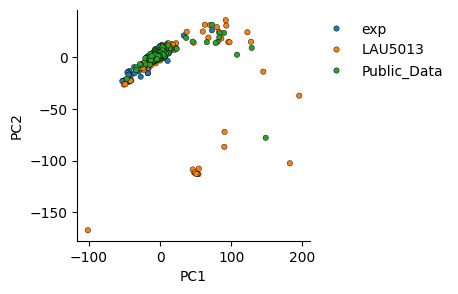

In [76]:
# load coordinate matrix
df = pd.read_pickle('coord_matrix.pkl')
coord_matrix = df.iloc[:,8:].to_numpy()

pca = PCA(n_components=2)
pcs = pca.fit_transform(coord_matrix)

df_pca = pd.DataFrame()
df_pca['PC1'] = pcs[:,0]
df_pca['PC2'] = pcs[:,1]
df_pca['PDB'] = df['PDB'].values
df_pca["PDB"] = df_pca["PDB"].apply(lambda x: os.path.basename(x).split('.')[0])
df_pca['batch'] = df['batch'].values

fig, ax = plt.subplots(1, 1, figsize=(3,3))

sns.scatterplot(df_pca, x='PC1', y='PC2', hue='batch', ax=ax, edgecolor='black', s=15)
ax.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
sns.despine()



## Project AF3-models (YF-epitope) into experimental space

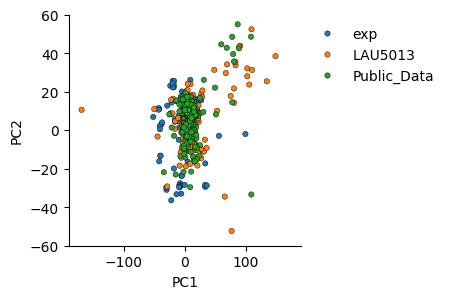

In [78]:
df = pd.read_pickle('coord_matrix.pkl')

# learn space based on experimental structures
df_exp = df[df['batch'] == 'exp']
coord_matrix_exp = df_exp.iloc[:,8:].to_numpy()
pca = PCA(n_components=2)
pcs_exp = pca.fit_transform(coord_matrix_exp)

# project AF3-models (YF-epitope) into experimental space
df_af3 = df[df['batch'] != 'exp']
coord_matrix_af3 = df_af3.iloc[:,8:].to_numpy()
pcs_af3 = pca.transform(coord_matrix_af3)

pcs = np.concatenate([pcs_exp, pcs_af3])

df_pca = pd.DataFrame()
df_pca['PC1'] = pcs[:,0]
df_pca['PC2'] = pcs[:,1]
df_pca['PDB'] = df['PDB'].values
df_pca["PDB"] = df_pca["PDB"].apply(lambda x: os.path.basename(x).split('.')[0])
df_pca['batch'] = df['batch'].values

fig, ax = plt.subplots(1, 1, figsize=(3,3))

sns.scatterplot(df_pca, x='PC1', y='PC2', hue='batch', ax=ax, edgecolor='black', s=15)
ax.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
ax.set_xlim(-190, 190)
ax.set_ylim(-60, 60)
sns.despine()



## Filter AF3 models by ipTM

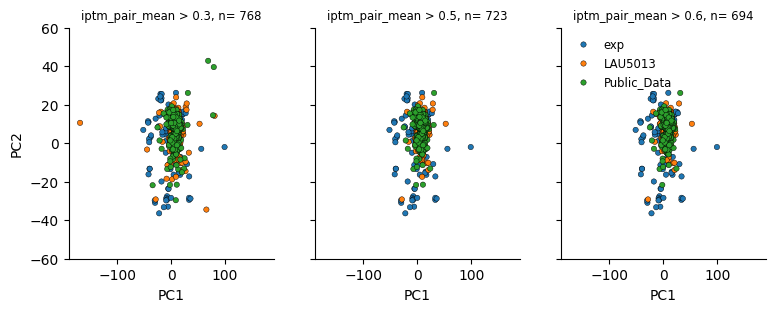

In [ ]:
# look at different plddt thresholds
topdir = 'data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']

df = pd.read_pickle('coord_matrix.pkl')

fig, axes = plt.subplots(1, 3, figsize=(3*3,3), sharey=True)
thresholds = [0.3, 0.5, 0.6]
filter_threshold = 0.5

for cnt, threshold in enumerate(thresholds):
    ax = axes[cnt]

    lst=[]
    for batch in batches:
        batch_short = batch.split('/')[0]
        csv_file = glob.glob(f'{topdir}/{batch}/*.csv')[0]
        df_af3_conf = pd.read_csv(csv_file)
        df_af3_conf = df_af3_conf[df_af3_conf["TEMPOproblem"].isna()]
        sel_ids = df_af3_conf.loc[df_af3_conf['AF3_iptm_pair_mean'] > threshold, 'id'].tolist()
        tmp = df[(df['batch'] == batch_short) & (df['PDB'].isin(sel_ids))]
        lst.append(tmp)

    df_af3 = pd.concat(lst)

    # learn space based on experimental structures
    df_exp = df[df['batch'] == 'exp']
    coord_matrix_exp = df_exp.iloc[:,8:].to_numpy()
    pca = PCA(n_components=2)
    pcs_exp = pca.fit_transform(coord_matrix_exp)

    # project AF3-models (YF-epitope) into experimental space
    coord_matrix_af3 = df_af3.iloc[:,8:].to_numpy()
    pcs_af3 = pca.transform(coord_matrix_af3)

    pcs = np.concatenate([pcs_exp, pcs_af3])

    df_pca = pd.concat([df_exp, df_af3])
    df_pca = df_pca[['PDB', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'batch']]
    df_pca['PC1'] = pcs[:,0]
    df_pca['PC2'] = pcs[:,1]
    # save reliable AF3 models
    if threshold == filter_threshold:
        df_pca.to_pickle('pca_af3_conf_adjusted.pkl')

    sns.scatterplot(df_pca, x='PC1', y='PC2', hue='batch', ax=ax, edgecolor='black', s=15)
    ax.legend([],[],frameon=False)
    ax.set_xlim(-190, 190)
    ax.set_ylim(-60, 60)   
    ax.set_title(f'iptm_pair_mean > {threshold}, n= {len(df_af3)}', fontsize='small')

axes[2].legend( frameon=False, loc='upper left', fontsize='small')
sns.despine()


/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_60605/366939967.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca_exp['TRAV-bin'] = np.where(df_pca_exp['TRAV'] == 'TRAV12-2', 'TRAV12-2', 'other')


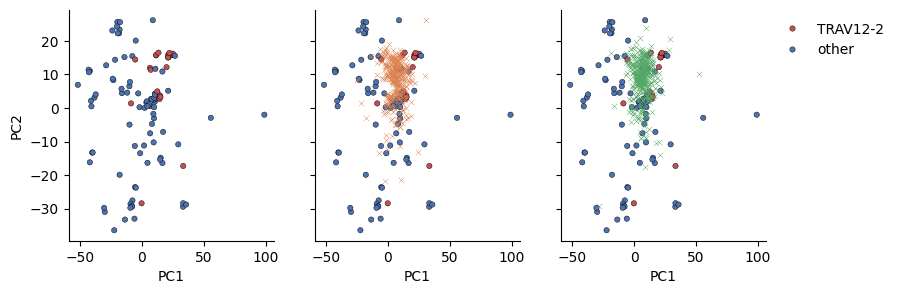

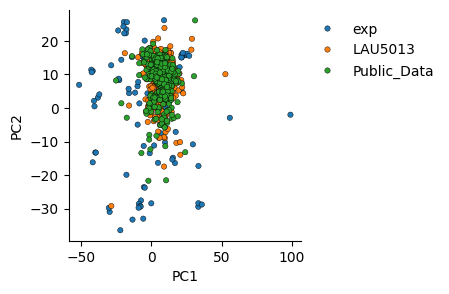

In [ ]:
std_pal = sns.color_palette("deep")

df_pca = pd.read_pickle('pca_af3_conf.pkl')
df_pca_exp = df_pca[df_pca['batch'] == 'exp']
df_pca_exp['TRAV-bin'] = np.where(df_pca_exp['TRAV'] == 'TRAV12-2', 'TRAV12-2', 'other')

fig, axes = plt.subplots(1, 3, figsize=(9,3), sharex=True, sharey=True)

ax = axes[0]
sns.scatterplot(df_pca_exp, x='PC1', y='PC2', hue='TRAV-bin', ax=ax, edgecolor='black', s=15, palette={'other': std_pal[0], 'TRAV12-2': std_pal[3]})
ax.legend([],[], frameon=False)

batches = ['Public_Data', 'LAU5013']
for cnt, batch in enumerate(batches):
    ax = axes[cnt+1]
    sns.scatterplot(df_pca_exp, x='PC1', y='PC2', hue='TRAV-bin', ax=ax, edgecolor='black', s=15, palette={'other': std_pal[0], 'TRAV12-2': std_pal[3]})

    df_pca_batch = df_pca[df_pca['batch'] == batch]
    sns.scatterplot(df_pca_batch, x='PC1', y='PC2', ax=ax, color=std_pal[cnt+1], s=15, marker='x')
    ax.legend([],[], frameon=False)

axes[2].legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
sns.despine()

fig, ax = plt.subplots(1, 1, figsize=(3,3))

sns.scatterplot(df_pca, x='PC1', y='PC2', hue='batch', ax=ax, edgecolor='black', s=15)
ax.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
sns.despine()


/var/folders/2v/m8p5rbh538sgyrgvrcyb210h0000gn/T/ipykernel_60605/132433298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca_exp['TRAV-bin'] = np.where(df_pca_exp['TRAV'] == 'TRAV12-2', 'TRAV12-2', 'other')


0.6904761904761905
0.7493540051679587


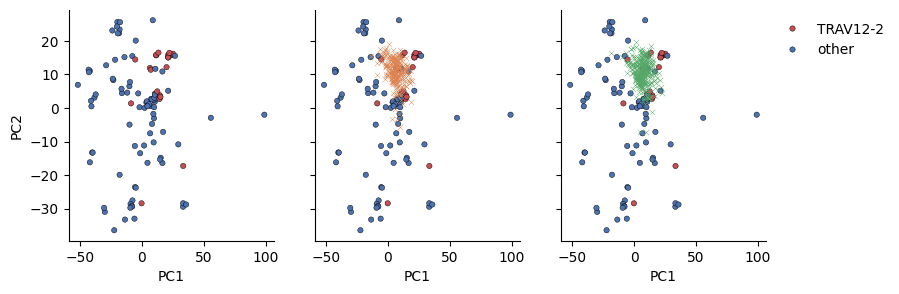

In [ ]:
# ignore non TRAV12-2 models
df_pca = pd.read_pickle('pca_af3_conf.pkl')


df_pca_exp = df_pca[df_pca['batch'] == 'exp']
df_pca_exp['TRAV-bin'] = np.where(df_pca_exp['TRAV'] == 'TRAV12-2', 'TRAV12-2', 'other')

fig, axes = plt.subplots(1, 3, figsize=(9,3), sharex=True, sharey=True)

ax = axes[0]
sns.scatterplot(df_pca_exp, x='PC1', y='PC2', hue='TRAV-bin', ax=ax, edgecolor='black', s=15, palette={'other': std_pal[0], 'TRAV12-2': std_pal[3]})
ax.legend([],[], frameon=False)

batches = ['Public_Data', 'LAU5013']
for cnt, batch in enumerate(batches):
    ax = axes[cnt+1]
    sns.scatterplot(df_pca_exp, x='PC1', y='PC2', hue='TRAV-bin', ax=ax, edgecolor='black', s=15, palette={'other': std_pal[0], 'TRAV12-2': std_pal[3]})

    df_pca_batch = df_pca[df_pca['batch'] == batch]
    before = len(df_pca_batch)
    df_pca_batch = df_pca_batch[df_pca_batch['TRAV'] == 'TRAV12-2']
    after = len(df_pca_batch)
    print(after/before)
    sns.scatterplot(df_pca_batch, x='PC1', y='PC2', ax=ax, color=std_pal[cnt+1], s=15, marker='x')
    ax.legend([],[], frameon=False)

axes[2].legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
sns.despine()


## Test different features

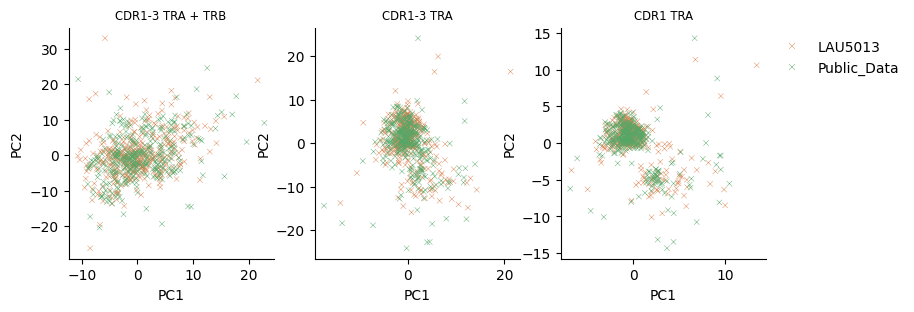

In [ ]:
topdir = 'data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']

df = pd.read_pickle('coord_matrix.pkl')
df = df[df['batch'] != 'exp']

# remove unreliable AF3 models
threshold = 0.5

for batch in batches:
    batch_short = batch.split('/')[0]
    csv_file = glob.glob(f'{topdir}/{batch}/*.csv')[0]
    df_af3_conf = pd.read_csv(csv_file)
    exclude_ids = df_af3_conf.loc[df_af3_conf['AF3_iptm_pair_mean'] < threshold, 'id'].tolist()
    df = df[~((df['batch'] == batch_short) & (df['PDB'].isin(exclude_ids)))]

coord_matrix = df.iloc[:,8:].to_numpy()

# select different subsets of coordinates
with open("min_cdr_lengths.pkl", "rb") as f:
    min_cdr_lengths = pickle.load(f)


selections = {'CDR1-3 TRA + TRB' : 3*sum(v for chain in min_cdr_lengths.values() for v in chain.values()),
              'CDR1-3 TRA' : 3*sum(min_cdr_lengths['TRA'].values()),
              'CDR1 TRA' : 3*min_cdr_lengths['TRA']['cdr1']}

fig, axes = plt.subplots(1, 3, figsize=(9,3))

for cnt, (label, limit) in enumerate(selections.items()):
    ax = axes[cnt]

    sel_coord_matrix = coord_matrix[:,:limit]
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(sel_coord_matrix)

    df_pca = df.copy()
    df_pca = df_pca[['PDB', 'TRAV', 'TRAJ', 'TRBV', 'TRBJ', 'batch']]
    df_pca['PC1'] = pcs[:,0]
    df_pca['PC2'] = pcs[:,1]

    # exclude weirdos
    weirdos = ['tcr2669', 'tcr0099', 'tcr1145']
    df_pca = df_pca[~((df_pca['PDB'].isin(weirdos)) & (df_pca['batch'] == 'LAU5013'))]

    sns.scatterplot(df_pca, x='PC1', y='PC2', hue='batch', ax=ax, s=15, marker='x', palette={'LAU5013': std_pal[1], 'Public_Data': std_pal[2]})
    ax.set_title(label, fontsize='small')
    ax.legend([],[], frameon=False)

    if label == 'CDR1 TRA':
        df_pca.to_pickle('pca_CDR1A.pkl')

axes[2].legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
sns.despine()


# Test different dimensionality reduction methods

In [15]:
# umap_env
import glob
import os

import pandas as pd
import numpy as np

import umap

import matplotlib.pyplot as plt
import seaborn as sns


/Users/roessner/miniconda3/envs/umap_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


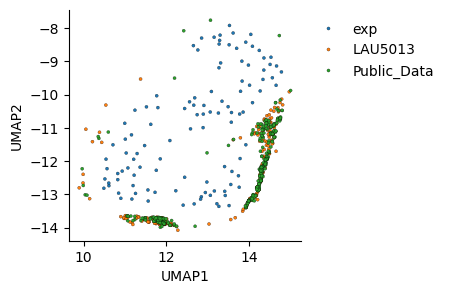

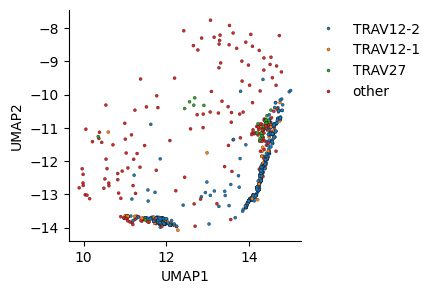

In [26]:
# umap
df = pd.read_pickle('coord_matrix.pkl')
lst = ['TRAV12-2', 'TRAV12-1', 'TRAV27']
df['TRAV-anno'] = np.where(df['TRAV'].isin(lst), df['TRAV'], 'other')

topdir = 'data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']

# remove unreliable AF3 models
threshold = 0.5

for batch in batches:
    batch_short = batch.split('/')[0]
    csv_file = glob.glob(f'{topdir}/{batch}/*.csv')[0]
    df_af3_conf = pd.read_csv(csv_file)
    exclude_ids = df_af3_conf.loc[df_af3_conf['AF3_iptm_pair_mean'] < threshold, 'id'].tolist()
    df = df[~((df['batch'] == batch_short) & (df['PDB'].isin(exclude_ids)))]


# learn space based on experimental structures
df_exp = df[df['batch'] == 'exp']
coord_matrix_exp = df_exp.iloc[:,8:-1].to_numpy()

umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=15,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

embedding_exp = umap_model.fit_transform(coord_matrix_exp)

# project AF3-models (YF-epitope) into experimental space
df_af3 = df[df['batch'] != 'exp']
coord_matrix_af3 = df_af3.iloc[:,8:-1].to_numpy()
embedding_af3 = umap_model.transform(coord_matrix_af3)

embedding = np.vstack([embedding_exp, embedding_af3])

df_pca = pd.DataFrame()
df_pca['UMAP1'] = embedding[:,0]
df_pca['UMAP2'] = embedding[:,1]
df_pca['PDB'] = df['PDB'].values
df_pca["PDB"] = df_pca["PDB"].apply(lambda x: os.path.basename(x).split('.')[0])
df_pca['batch'] = df['batch'].values
df_pca['TRAV-anno'] = df['TRAV-anno'].values

fig, ax = plt.subplots(1, 1, figsize=(3,3))

sns.scatterplot(df_pca, x='UMAP1', y='UMAP2', hue='batch', ax=ax, edgecolor='black', s=5)
ax.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
sns.despine()

order = ['TRAV12-2', 'TRAV12-1', 'TRAV27', 'other']
df_pca['TRAV-anno'] = pd.Categorical(df_pca['TRAV-anno'], categories=order, ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(3,3))

sns.scatterplot(df_pca, x='UMAP1', y='UMAP2', hue='TRAV-anno', ax=ax, edgecolor='black', s=5)
ax.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
sns.despine()



In [18]:
df = pd.read_pickle('coord_matrix.pkl')
print(df.head())

    PDB        TRAV    TRAJ        cdr3_TRA     TRBV     TRBJ        cdr3_TRB  \
0  1ao7    TRAV12-2  TRAJ24     AVttdswgKLQ  TRBV6-5  TRBJ2-7  ASrPglaggrpEQY   
1  1bd2  TRAV29/DV5  TRAJ54      AAmegaqkLV  TRBV6-5  TRBJ2-7   ASSypgggFyEQY   
2  1mi5    TRAV26-2  TRAJ52  ILPlaggstyGKLT  TRBV7-8  TRBJ2-7     ASSlgqayEQY   
3  1qrn    TRAV12-2  TRAJ24     AVttdswgkLQ  TRBV6-5  TRBJ2-7  ASrPglaggrpEQY   
4  1qse    TRAV12-2  TRAJ24     AVttdswgKLQ  TRBV6-5  TRBJ2-7  ASRpglaggrpEQY   

  batch          0          1  ...      92         93      94         95  \
0   exp  91.323997  18.611000  ... -13.512  91.277000  11.848 -13.081000   
1   exp  92.317001  17.250999  ... -14.153  88.837997  13.223 -14.073000   
2   exp  94.149002  16.422001  ... -18.309  82.377998   6.967 -20.936001   
3   exp  91.116997  18.399000  ... -13.297  91.109001  11.724 -12.880000   
4   exp  91.082001  18.690001  ... -13.275  90.719002  12.344 -13.038000   

          96      97         98         99        100   

## Clustering on CDR1A PCA

PDB         tcr0673
TRAV       TRAV12-2
TRAJ         TRAJ44
TRBV        TRBV5-4
TRBJ        TRBJ2-7
batch       LAU5013
PC1       -0.463898
PC2        1.158558
cluster           0
Name: 107, dtype: object
PDB            tcr0302
TRAV            TRAV27
TRAJ            TRAJ58
TRBV             TRBV9
TRBJ           TRBJ2-1
batch      Public_Data
PC1           2.800949
PC2           -4.99519
cluster              1
Name: 105, dtype: object


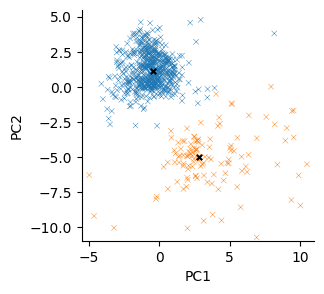

In [49]:
from sklearn.cluster import KMeans

df_pca = pd.read_pickle('pca_CDR1A.pkl')
pcs = df_pca[['PC1', 'PC2']].values

# KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  
labels = kmeans.fit_predict(pcs)

df_pca['cluster'] = labels
df_pca['cluster'] = df_pca['cluster'].map({0: 1, 1: 0})
df_pca.to_pickle('pca_CDR1A_cluster.pkl')

fig, ax = plt.subplots(1, 1, figsize=(3,3))
sns.scatterplot(df_pca, x='PC1', y='PC2', hue='cluster', ax=ax, s=15, marker='x')
ax.set_xlim(-5.5, 11)
ax.set_ylim(-11, 5.5)
ax.legend([],[], frameon=False)
sns.despine()

# extract models
batches_anno = {
    'LAU5013' : 'data_julien/LAU5013/YF_LAU5013_sc_WT',
    'Public_Data' : 'data_julien/Public_Data/YF_public_pairedData_20251010'
}

if os.path.exists('YF_CDR1A_clusters'):
        shutil.rmtree('YF_CDR1A_clusters')

densest_points = []
for cluster in range(2):
    outdir = f'YF_CDR1A_clusters/{cluster}'
    os.makedirs(outdir, exist_ok=True)

    for batch, path in batches_anno.items():
        tmp = df_pca[(df_pca['cluster'] == cluster) & (df_pca['batch'] == batch)]
        ids = tmp['PDB'].values

        for id in ids:
            src_file = f'{path}/model_pdb_align_exp/{id}.pdb'
            dst_file = f'{outdir}/{id}_{batch}.pdb'
            shutil.copy(src_file, dst_file)

    # get medoid (=densest actual point in each cluster)
    df_cluster = df_pca.loc[df_pca['cluster'] == cluster].reset_index(drop=True)

    cluster_points = df_cluster[['PC1', 'PC2']].values
    
    dists = pairwise_distances(cluster_points) # pairwise distances within cluster
    mean_dists = dists.mean(axis=1) # mean distance to all other points
    medoid_idx = np.argmin(mean_dists) # index of medoid
    densest_points.append(cluster_points[medoid_idx])

    closest_model = df_cluster.loc[medoid_idx]
    print(closest_model)
    
    # Copy the corresponding PDB file
    for batch, path in batches_anno.items():
        if closest_model['batch'] == batch:
            src_file = f"{path}/model_pdb_align_exp/{closest_model['PDB']}.pdb"
            dst_file = f"YF_CDR1A_clusters/cluster_{cluster}_{closest_model['PDB']}_{batch}_centroid.pdb"
            shutil.copy(src_file, dst_file)
    

densest_points = np.array(densest_points)
ax.scatter(densest_points[:,0], densest_points[:,1], c='black', s=15, marker='x')

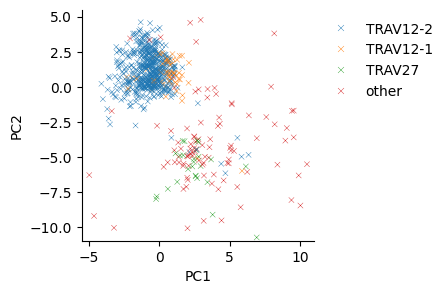

In [50]:
# color by TRAV
df_pca = pd.read_pickle('pca_CDR1A.pkl')

lst = ['TRAV12-2', 'TRAV12-1', 'TRAV27']
df_pca['tmp'] = np.where(df_pca['TRAV'].isin(lst), df_pca['TRAV'], 'other')
order = ['TRAV12-2', 'TRAV12-1', 'TRAV27', 'other']
df_pca['tmp'] = pd.Categorical(df_pca['tmp'], categories=order, ordered=True)

fig, ax = plt.subplots(1, 1, figsize=(3,3))
sns.scatterplot(df_pca, x='PC1', y='PC2', hue='tmp', ax=ax, s=15, marker='x')
ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')
ax.set_xlim(-5.5, 11)
ax.set_ylim(-11, 5.5)
sns.despine()

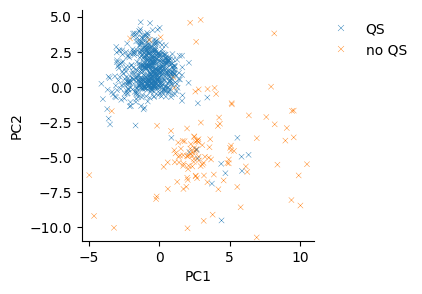

In [51]:
# color by QS in CDR1a
df_pca = pd.read_pickle('pca_CDR1A.pkl')

# annotate CDR1a sequence
batches_anno = {
    'exp' : 'tcr_pdbs_chains_david_mhci_fixed.csv',
    'LAU5013' : 'data_julien/LAU5013/YF_LAU5013_sc_WT/YF_LAU5013_sc_WT_AF3_anno.csv',
    'Public_Data' : 'data_julien/Public_Data/YF_public_pairedData_20251010/YF_public_pairedData_20251010_AF3_anno.csv'
}

lst=[]
for batch, csv_file in batches_anno.items():
    if batch == 'exp':
        df_anno = pd.read_csv(csv_file, sep=';')
    else:
        df_anno = pd.read_csv(csv_file)
        df_anno = df_anno.rename(columns={'id':'PDB', 'cdr1_TRA':'CDR1A'})

    df_anno = df_anno[['PDB', 'CDR1A']]
    df_anno['CDR1A'] = df_anno['CDR1A'].str.upper()

    df_anno['batch'] = batch
    lst.append(df_anno)

anno = pd.concat(lst)

df_merged = pd.merge(anno, df_pca, on=['PDB', 'batch'])
df_merged['QS'] = np.where(df_merged['CDR1A'].str.contains('QS', na=False), 'QS', 'no QS')

fig, ax = plt.subplots(1, 1, figsize=(3,3))
sns.scatterplot(df_merged, x='PC1', y='PC2', hue='QS', ax=ax, s=15, marker='x')
ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')
ax.set_xlim(-5.5, 11)
ax.set_ylim(-11, 5.5)
sns.despine()

# Extract dataframes for motif calculation

In [ ]:
# curate dataframe for motif extraction
df = pd.read_pickle('pca_CDR1A_cluster.pkl')

topdir = 'data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']

lst=[]
for batch in batches:
    batch_short = batch.split('/')[0]
    
    # CDRs annotated with tcr_cdr_annotation.R
    csv_file = glob.glob(f'{topdir}/{batch}/*.csv')[0]
    anno = pd.read_csv(csv_file)[['id', 'cdr3_TRA', 'cdr3_TRB']]
    anno = anno.rename(columns={'id':'PDB'})
    anno['batch'] = batch_short
    lst.append(anno)

anno = pd.concat(lst)
df_merged = pd.merge(df, anno, on=['PDB', 'batch'])
df_merged.to_csv("pca_CDR1A_cluster.csv", index=False)

In [ ]:
topdir = 'data_julien'
batches = ['LAU5013/YF_LAU5013_sc_WT', 'Public_Data/YF_public_pairedData_20251010']

threshold = 0.5

lst=[]
for batch in batches:
    batch_short = batch.split('/')[0]
    csv_file = glob.glob(f'{topdir}/{batch}/*.csv')[0]
    df = pd.read_csv(csv_file)
    df = df[df["TEMPOproblem"].isna()]
    sel_ids = df.loc[df['AF3_iptm_pair_mean'] < threshold, 'id'].tolist()
    df = df[df['id'].isin(exclude_ids)]
    df = df[['id','TRAV','TRAJ','cdr3_TRA','TRBV','TRBJ','cdr3_TRB','AF3_iptm_pair_mean']]
    df = df.dropna()
    df['batch'] = batch_short
    lst.append(df)

df = pd.concat(lst)
df.to_csv('low_confidence_models.csv', index=False)
print(df)


21
12
40
40
          id          TRAV    TRAJ           cdr3_TRA      TRBV     TRBJ  \
4    tcr0008      TRAV12-2  TRAJ30         CAVGDDKIIF  TRBV20-1  TRBJ2-3   
6    tcr0012       TRAV1-2  TRAJ12       CAVMDSSYKLIF   TRBV6-1  TRBJ2-1   
16   tcr0031      TRAV12-2  TRAJ34        CAVGTTDKLIF   TRBV7-6  TRBJ2-7   
34   tcr0063      TRAV12-2  TRAJ49         CAVDGNQFYF    TRBV27  TRBJ2-7   
61   tcr0113      TRAV12-2  TRAJ11        CALSGYSTLTF    TRBV15  TRBJ1-6   
88   tcr0164        TRAV27  TRAJ15      CAGADQAGTALIF     TRBV9  TRBJ2-1   
89   tcr0166    TRAV29/DV5  TRAJ30        CAASADDKIIF   TRBV5-6  TRBJ2-2   
106  tcr0197      TRAV12-2  TRAJ30         CAGGDDKIIF  TRBV12-3  TRBJ2-7   
118  tcr0216      TRAV12-2  TRAJ30         CAPGDDKIIF     TRBV9  TRBJ2-1   
122  tcr0223        TRAV10  TRAJ35      CVAGAGFGNVLHC   TRBV4-2  TRBJ2-7   
127  tcr0233        TRAV17  TRAJ20      CATDPAGDYKLSF   TRBV4-1  TRBJ2-7   
196  tcr0363      TRAV12-2  TRAJ13      CALYSGGYQKVTF   TRBV6-5  TRBJ1-3   


         PDB        TRAV    TRAJ        cdr3_TRA     TRBV     TRBJ  \
0       1ao7    TRAV12-2  TRAJ24     AVttdswgKLQ  TRBV6-5  TRBJ2-7   
1       1bd2  TRAV29/DV5  TRAJ54      AAmegaqkLV  TRBV6-5  TRBJ2-7   
2       1mi5    TRAV26-2  TRAJ52  ILPlaggstyGKLT  TRBV7-8  TRBJ2-7   
3       1qrn    TRAV12-2  TRAJ24     AVttdswgkLQ  TRBV6-5  TRBJ2-7   
4       1qse    TRAV12-2  TRAJ24     AVttdswgKLQ  TRBV6-5  TRBJ2-7   
..       ...         ...     ...             ...      ...      ...   
930  tcr0385    TRAV12-2  TRAJ31      CAGANARLMF  TRBV7-6  TRBJ2-2   
931  tcr0386      TRAV27  TRAJ30   CAGVLSRDDKIIF  TRBV7-6  TRBJ1-2   
932  tcr0387    TRAV12-2  TRAJ31      CAVTGARLMF   TRBV19  TRBJ2-7   
933  tcr0388    TRAV12-2  TRAJ27      CAVSAGKSTF  TRBV6-1  TRBJ2-7   
934  tcr0389      TRAV16   TRAJ4    CALSGGYNKLIF  TRBV4-3  TRBJ1-2   

              cdr3_TRB        batch          0          1  ...         95  \
0       ASrPglaggrpEQY          exp  91.323997  18.611000  ... -13.081000   
1    

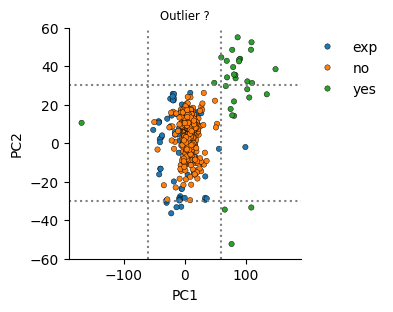

In [79]:
df = pd.read_pickle('coord_matrix.pkl')

# learn space based on experimental structures
df_exp = df[df['batch'] == 'exp']
coord_matrix_exp = df_exp.iloc[:,8:].to_numpy()
pca = PCA(n_components=2)
pcs_exp = pca.fit_transform(coord_matrix_exp)

# project AF3-models (YF-epitope) into experimental space
df_af3 = df[df['batch'] != 'exp']
coord_matrix_af3 = df_af3.iloc[:,8:].to_numpy()
pcs_af3 = pca.transform(coord_matrix_af3)

pcs = np.concatenate([pcs_exp, pcs_af3])

df_pca = df.copy()
df_pca['PC1'] = pcs[:,0]
df_pca['PC2'] = pcs[:,1]
df_pca['PDB'] = df['PDB'].values
df_pca["PDB"] = df_pca["PDB"].apply(lambda x: os.path.basename(x).split('.')[0])
df_pca['batch'] = df['batch'].values
df_pca['outlier'] = np.where(
    df_pca['batch'] == 'exp',
    'exp',
    np.where(
        (df_pca['PC1'] > -60) & (df_pca['PC1'] < 60) &
        (df_pca['PC2'] > -30) & (df_pca['PC2'] < 30),
        'no',
        'yes'
    )
)


fig, ax = plt.subplots(1, 1, figsize=(3,3))

sns.scatterplot(df_pca, x='PC1', y='PC2', hue='outlier', ax=ax, edgecolor='black', s=15)
ax.legend(bbox_to_anchor=(1,1), frameon=False, loc='upper left')
ax.set_xlim(-190, 190)
ax.set_ylim(-60, 60)
ax.axvline(-60, color='grey', linestyle=':')
ax.axvline(60, color='grey', linestyle=':')
ax.axhline(-30, color='grey', linestyle=':')
ax.axhline(30, color='grey', linestyle=':')
ax.set_title('Outlier ?', fontsize='small')
sns.despine()
print(df_pca)
df_pca = df_pca[['PDB', 'TRAV', 'TRAJ', 'cdr3_TRA', 'TRBV', 'TRBJ', 'cdr3_TRB', 'batch', 'PC1', 'PC2', 'outlier']]
df_pca.to_csv('outlier_models.csv', index=False)